### Initial Demonstrations of Tangermeme

As an initial demonstration of the capabilities of tangermeme, we showed off the timings for one-hot encoding the entirety of chr1, how to avoid silent failures when running DeepLIFT/SHAP with unregistered model components, and how operations can be stacked on each other to decompose the sequence manipulation and the model operation step.

#### One-Hot Encoding Timings

First, we timed various implementations of one-hot encodings across packages. To demonstrate the a compute-intensive case, we show the time it takes to one-hot encode the entire human genome. To avoid differences in whether an implementation is multi-threaded or single-threaded, we forced using only a single thread. Part of the reasoning here is because multi-threaded implementations will have vastly different performance profiles depending on the hardware of the user (not only the number of CPUs/threads but also how well thread communication is handled) and so limiting to a single thread provides a fairer comparison. 

Because some of the evaluations below take quite some time to perform repeatedly, we have commented out the actual calls to those functions and instead read in pre-computed results. However, this still shows how long each of the functions takes and what our procedure for calling those functions is. Feel free the uncomment those lines to perform the timings yourself on your hardware.

Let's start off by loading up chr1.

In [1]:
import numpy

import pyfaidx
import numba
numba.set_num_threads(1)


fa = pyfaidx.Fasta("/users/jacob.schreiber/common/hg38.fa")
X = fa['chr1'][:].seq.upper()
print(len(X))

n_repeats = 10
timings = numpy.zeros((6, n_repeats), dtype=numpy.float32)

248956422


Now, let's create a general-purpose timing wrapper that takes in the function and runs it a specified number of times. Having a wrapper function like this will diminish the potential for errors across comparisons.

In [2]:
import time

def time_function(f, X, n_repeats):
    timings = numpy.zeros(n_repeats)
    f(X)
    
    for i in range(n_repeats):
        tic = time.time()
        
        f(X)
        
        timings[i] = time.time() - tic
    
    return timings

First, we will time tangermeme. Remember that we have commented out the actual running of the function and so the time is incorrectly shown as "0.0". 

In [3]:
from tangermeme.utils import one_hot_encode

#timings[0] = time_function(one_hot_encode, X, n_repeats=n_repeats)
timings[0].mean().item(), timings[0].std().item()

(0.0, 0.0)

Next, we will look at SeqPro. Doing a one-hot encoding with SeqPro requires creating a `NucleotideAlphabet` object that then has a `ohe` method. Creating this object does not take that much time, but we will exclude this time from the actual comparison. This slightly disadvantages tangermeme, which still has to figure out what to do with an alphabet of letters as part of the running time.

In [4]:
from seqpro.alphabets import NucleotideAlphabet

n = NucleotideAlphabet("ACGT", "TGCA")

#timings[1] = time_function(n.ohe, X, n_repeats=n_repeats)
timings[1].mean().item(), timings[1].std().item()

(0.0, 0.0)

Next, we will compare against crested, which also has a one-hot encoding function.

In [5]:
from crested.utils import one_hot_encode_sequence

#timings[2] = time_function(one_hot_encode_sequence, X, n_repeats=n_repeats)
timings[2].mean().item(), timings[1].std().item()

(0.0, 0.0)

Next, we will compare against gReLU, which also has a one-hot encoding function.

In [6]:
from grelu.sequence.format import strings_to_one_hot

#timings[3] = time_function(strings_to_one_hot, X, n_repeats=n_repeats)
timings[3].mean().item(), timings[1].std().item()

/users/jacob.schreiber/anaconda3/envs/tangermeme/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(0.0, 0.0)

Next, we will compare against selene, whose one-hot encoding function has to be wrapped to make it more compatible with our expected usage.

In [7]:
from selene_sdk.sequences.sequence import sequence_to_encoding

BASE_TO_INDEX = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
BASES_ARR = ['A', 'C', 'G', 'T']

selene_ohe = lambda x: sequence_to_encoding(x, BASE_TO_INDEX, BASES_ARR)

#timings[4] = time_function(selene_ohe, X, n_repeats=n_repeats)
timings[4].mean().item(), timings[3].std().item()

(0.0, 0.0)

Finally, we will compare against the one-hot encoding function in the official ChromBPNet repository.

In [8]:
import numpy as np

def chrombpnet_dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

#timings[5] = time_function(chrombpnet_dna_to_one_hot, X, n_repeats=n_repeats)
timings[5].mean().item(), timings[4].std().item()

(0.0, 0.0)

Be careful here -- we can either save the timings (commented out by default) or load the pre-calculated ones.

In [9]:
#numpy.save("ohe_timings.npy", timings)
timings = numpy.load("ohe_timings.npy")

Now, we can plot the mean and standard deviation of each run.

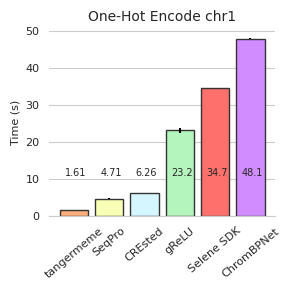

In [10]:
import matplotlib
matplotlib.use('pdf')

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

colors = ['#FCAE7C', '#F9FFB5', '#D6F6FF', '#B3F5BC', '#FD706B', '#D18DFF']
names = ['tangermeme', 'SeqPro', 'CREsted', 'gReLU', 'Selene SDK', 'ChromBPNet']
t = timings.mean(axis=1)

plt.figure(figsize=(3, 3))
plt.bar(range(6), t, facecolor=colors, edgecolor='0.2')
plt.errorbar(range(6), t, yerr=timings.std(axis=1), fmt='none', c='k', barsabove=True)

for i in range(timings.shape[0]):
    plt.text(i-0.25, 11, s="{:3.3}".format(t[i]), fontsize=7)

plt.title("One-Hot Encode chr1", fontsize=10)
plt.ylabel("Time (s)", fontsize=8)
plt.xticks(range(6), names, rotation=40, fontsize=8)
plt.yticks(fontsize=8)


seaborn.despine(left=True)
plt.grid(False, axis="x") 
plt.tight_layout()
plt.savefig('tangermeme-fig1-timings.pdf')
plt.show()

#### Convergence Deltas with Captum

Although DeepLIFT/SHAP have been extensively used as feature attribution algorithms, their implementations are surprisingly brittle. Specifically, they rely on overriding the forward and backward pass operations on *solely non-linear* operations. How do the implementations know which operations are non-linear? Good question -- and exactly where the issues arise. I have written more extensively about this issue [here](https://tangermeme.readthedocs.io/en/latest/vignettes/Attribution_Trickiness_and_DeepLiftShap_Implementations.html) but the gist is basically that almost all other implementations will silently fail if you do not register all your non-linear operations correctly. This can include:

1. Failing to add your custom non-linear layer to their internal (sometimes hard to find) dictionary of operations
2. Failing to add a built-in non-linear layer that simply is not already in their internal dictionary, e.g. for an operation added to PyTorch after the DeepLIFT implementation was released
3. Re-using non-linear layers, like activations, multiple times in the same forward function
4. Creating non-linear layers in the forward function instead of in __init__ 
5. Using non-linear operations outside the context of a registered torch.nn.Module object, e.g. running `torch.exp` within the forward function

Each of these can cause a non-linear operation to be treated as a linear one, and when that happens the convergence property of DeepLIFT/SHAP no longer holds. When the divergence is too high, tangermeme will issue a warning.

Let's see this in action with a GATA2 BPNet model.

In [11]:
import torch

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import ProfileWrapper
from bpnetlite.bpnet import CountWrapper

model = torch.load("/users/jacob.schreiber/models/bpnet/GATA2.torch")
model = ControlWrapper(model)

profile_model = ProfileWrapper(model)
count_model = CountWrapper(model)

As a sequence to analyze, let's make a random one-hot encoded sequence where we stick a high affinity GATA motif into the middle. Because we will be using different implementations of DeepLIFT, we should also pre-shuffle our sequences to make sure the results from the two methods are comparable.

In [12]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute
from tangermeme.ersatz import dinucleotide_shuffle

X = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X = substitute(X, "AGATAAG")

X_dinuc = dinucleotide_shuffle(X, random_state=0)

X = X.cuda()
X_dinuc = X_dinuc.cuda()

First, let's run the two implementations on the count head of the BPNet model. This should be fairly straightforward as there are no additional non-linear operations that would need to be registered.

In [13]:
import numpy
from captum.attr import DeepLiftShap

from tangermeme.predict import predict
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.deep_lift_shap import hypothetical_attributions

X_attr_t = deep_lift_shap(count_model, X, references=X_dinuc, raw_outputs=True)
y_hat = predict(count_model, X)
y_dinuc_hat = predict(count_model, X_dinuc[0])

input_diff = torch.sum((X - X_dinuc) * X_attr_t.cuda(), dim=(2, 3))[0].numpy(force=True)
output_diff = (y_hat - y_dinuc_hat)[:, 0].numpy(force=True)

count_deltas_t = numpy.abs(input_diff - output_diff)

###

X_attr_c, count_deltas_c = DeepLiftShap(count_model).attribute(X, X_dinuc[0], return_convergence_delta=True)
count_deltas_c = numpy.abs(count_deltas_c.numpy(force=True))

/users/jacob.schreiber/anaconda3/envs/tangermeme/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Other than a generic warning about hooks being set, both implementations seem to run without issue. There is a little bit of additional code for calculating the deltas from the tangerememe attributions.

Next, let's try calculating attributions for the profile head. This involves a non-linearity, as the 1000 bp output is converted to a single number by doing the dot product between itself and the exponentiated version of itself. This operation can be easily registered in tangermeme through the `additional_nonlinear_ops` argument and using the `_nonlinear` tag.

In [14]:
from bpnetlite.bpnet import _ProfileLogitScaling
from tangermeme.deep_lift_shap import _nonlinear

X_attr_t = deep_lift_shap(profile_model, X, references=X_dinuc, 
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, raw_outputs=True)

y_hat = predict(profile_model, X)
y_dinuc_hat = predict(profile_model, X_dinuc[0])

input_diff = torch.sum((X - X_dinuc) * X_attr_t.cuda(), dim=(2, 3))[0].numpy(force=True)
output_diff = (y_hat - y_dinuc_hat)[:, 0].numpy(force=True)

profile_deltas_t = numpy.abs(input_diff - output_diff)

###

X_attr_c, profile_deltas_c = DeepLiftShap(profile_model).attribute(X, X_dinuc[0], return_convergence_delta=True)
profile_deltas_c = numpy.abs(profile_deltas_c.numpy(force=True))

Both implementations seem to run without warnings. What happens when we plot the convergence deltas?

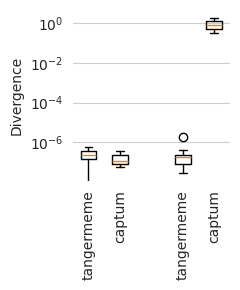

In [15]:
plt.figure(figsize=(2.5, 3))

plt.boxplot([count_deltas_t, count_deltas_c, [], profile_deltas_t, profile_deltas_c])

plt.ylabel("Divergence")
plt.yscale("log")
plt.xticks([1, 2, 4, 5], ['tangermeme', 'captum', 'tangermeme', 'captum'], rotation=90)
plt.grid(False, axis='x')

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig('tangermeme-fig1-divergence.pdf')
plt.show()

Looks like tangermeme and captum product attributions with similarly low divergences for the count model (the left two boxes) whereas captum produces attributions with very high divergences for the profile model, even though it did not raise a warning suggesting that something was wrong. In contrast, by registering the component with tangermeme, the convergence deltas remain similarly low as the count model.

#### Operation Stacking

One of the strengths of tangermeme is that operations can be stacked on top of each other in a flexible manner. Frequently, this comes in the form of operations like variant effect prediction where most implementations fuse together the sequence manipulation operation (the substitution) with the model operation (the prediction). But these operations do not have to be fused together -- any pair of sequence and model operations can be stacked together. For instance, given the same substitution, one may wish to then run DeepLIFT or some other attribution method to evaluate how a substitution influences how a sequence gets read. One may wish to run an in silico marginalization but report attributions instead of predictions. Or you may have some custom function that you want to apply before and after the sequence operation happens.

Let's see this in action with a ChromBPNet model applied to a randomly generated sequence.

In [17]:
from bpnetlite import BPNet
from tangermeme.utils import random_one_hot

X = random_one_hot((100, 4, 2114), probs=[0.28, 0.22, 0.22, 0.28], random_state=0).float()
model = BPNet.from_chrombpnet("/users/jacob.schreiber/models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")

The subsequent plots are panels for the figure below. I will only include brief descriptions of what each one is.

First, we have predictions when marginalizing an AP-1 motif.

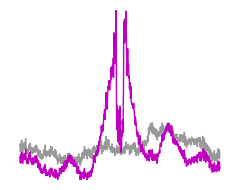

In [18]:
from tangermeme.marginalize import marginalize

y_before, y_after = marginalize(model, X, "ATGATGTCAT")

yb = torch.nn.functional.softmax(y_before[0].mean(dim=(0, 1)), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(dim=(0, 1)), dim=-1)


###

plt.figure(figsize=(2.5, 2))

plt.plot(yb, c='0.6', linewidth=1)
plt.plot(ya, c='m', linewidth=1)
plt.ylim(ya.min(), ya.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-marginalization-pred.pdf')
plt.show()

Now, DeepLIFT/SHAP attributions with the same motif.

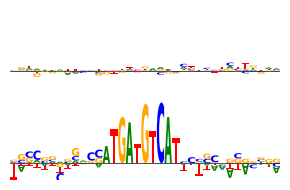

In [19]:
from bpnetlite.attribute import deep_lift_shap  # Note that we use the bpnet-lite version which registers the BPNet-specific non-linearities
from tangermeme.plot import plot_logo

y_before, y_after = marginalize(ProfileWrapper(model), X, "ATGATGTCAT", func=deep_lift_shap, n_shuffles=1, random_state=0)
yb = y_before[:, :, 1040:1075].mean(dim=0)
ya = y_after[:, :, 1040:1075].mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(ya.min(), ya.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(ya.min(), ya.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-marginalization-attr.pdf')
plt.show()

Finally, saturation mutagenesis on the same motif.

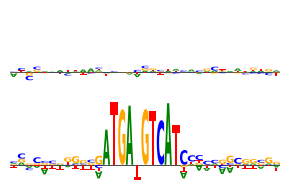

In [20]:
from tangermeme.saturation_mutagenesis import saturation_mutagenesis

y_before, y_after = marginalize(ProfileWrapper(model), X, "ATGATGTCAT", func=saturation_mutagenesis,
    additional_func_kwargs={'start': 1040, 'end': 1075})

yb = y_before.mean(dim=0)
ya = y_after.mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(ya.min(), ya.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(ya.min(), ya.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-marginalization-ism.pdf')
plt.show()

Now, we consider ablations. In this case we begin with a sequence where the AP-1 motif has been substituted into the middle and we ablate it out using a dinucleotide shuffle.

Here are the predictions.

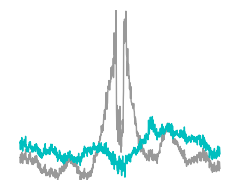

In [21]:
from tangermeme.ablate import ablate
from tangermeme.ersatz import substitute

X_ = substitute(X, "ATGATGTCAT")

y_before, y_after = ablate(model, X_, 1030, 1075, n=1)

yb = torch.nn.functional.softmax(y_before[0].mean(dim=(0, 1)), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(dim=(0, 1, 2)), dim=-1)

###

plt.figure(figsize=(2.5, 2))

plt.plot(yb, c='0.6', linewidth=1)
plt.plot(ya, c='c', linewidth=1)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ablate-pred.pdf')
plt.show()

Here are the DeepLIFT attributions.

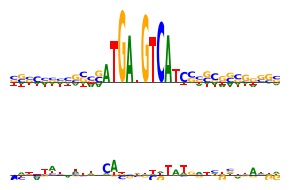

In [22]:
y_before, y_after = ablate(ProfileWrapper(model), X_, 1030, 1075, func=deep_lift_shap, n=1, random_state=0)

yb = y_before[:, :, 1040:1075].mean(dim=0)
ya = y_after[:, 0, :, 1040:1075].mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ablate-attr.pdf')
plt.show()

Finally, here is the saturation mutagenesis.

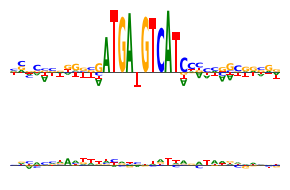

In [23]:
y_before, y_after = ablate(ProfileWrapper(model), X_, 1030, 1075, func=saturation_mutagenesis, n=1, random_state=0,
    additional_func_kwargs={'start': 1040, 'end': 1075})

yb = y_before.mean(dim=0)
ya = y_after[:, 0].mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ablate-ism.pdf')
plt.show()

Lastly, we will consider the case where the sequence operation is a substitution.

First, we can get predictions from the model.

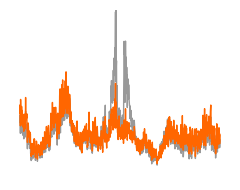

In [24]:
from tangermeme.variant_effect import substitution_effect
 
y_before, y_after = substitution_effect(model, X_[16:17], [[0, 1054, 0]])

yb = torch.nn.functional.softmax(y_before[0].mean(dim=(0, 1)), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(dim=(0, 1)), dim=-1)

###

plt.figure(figsize=(2.5, 2))

#plt.subplot(211)
plt.plot(yb, c='0.6', linewidth=1)

plt.plot(ya, c='#FF6600', linewidth=1)
plt.ylim(0, yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ve-pred.pdf')
plt.show()

We can get DeepLIFT attributions.

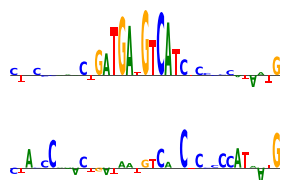

In [27]:
y_before, y_after = substitution_effect(ProfileWrapper(model), X_[16:17], [[0, 1054, 0]], func=deep_lift_shap, random_state=0)

yb = y_before[:, :, 1040:1075].mean(dim=0)
ya = y_after[:, :, 1040:1075].mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ve-attr.pdf')
plt.show()

And we can get saturation mutagenesis.

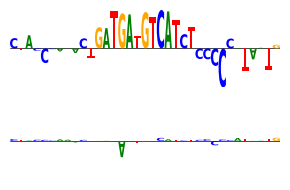

In [28]:
y_before, y_after = substitution_effect(ProfileWrapper(model), X_[16:17], [[0, 1054, 0]], func=saturation_mutagenesis)

yb = y_before[:, :, 1040:1075].mean(dim=0)
ya = y_after[:, :, 1040:1075].mean(dim=0)

###

plt.figure(figsize=(3, 2))

plt.subplot(211)
plot_logo(yb)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.subplot(212)
plot_logo(ya)
plt.ylim(yb.min(), yb.max())
plt.axis('off')

plt.tight_layout()
plt.savefig('tangermeme-fig1-ve-ism.pdf')
plt.show()